In [ ]:
"""
Notebook 2A: Data Augmentation (Non-Geometric)
Construction Safety Detection

Augmentasi yang diterapkan (TIDAK MENGUBAH GEOMETRIS):
1. Grayscale (Hitam Putih)
2. Brightness adjustment (Pencahayaan)
3. Contrast adjustment (Kontras)
4. Gaussian Noise
5. Blur
6. Saturation adjustment
"""

import os
import cv2
import numpy as np
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



# 1. LOAD CONFIGURATION

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Capstone 4/extracted/data.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("Dataset Configuration:")
print(f"Classes: {config['names']}")
print(f"Number of classes: {config['nc']}")

Dataset Configuration:
Classes: ['helmet', 'no-helmet', 'no-vest', 'person', 'vest']
Number of classes: 5



# 2. AUGMENTATION FUNCTIONS

In [ ]:


def add_gaussian_noise(image, mean=0, sigma=25):
    """Tambahkan Gaussian noise ke gambar"""
    noise = np.random.normal(mean, sigma, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    return noisy_image

def adjust_brightness(image, factor=1.2):
    """
    Ubah kecerahan gambar
    factor > 1: lebih terang
    factor < 1: lebih gelap
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[:, :, 2] = hsv[:, :, 2] * factor
    hsv[:, :, 2] = np.clip(hsv[:, :, 2], 0, 255)
    brightened = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
    return brightened

def adjust_contrast(image, alpha=1.5):
    """
    Ubah kontras gambar
    alpha > 1: kontras lebih tinggi
    alpha < 1: kontras lebih rendah
    """
    contrasted = cv2.convertScaleAbs(image, alpha=alpha, beta=0)
    return contrasted

def to_grayscale_3channel(image):
    """Convert ke grayscale tapi tetap 3 channel (untuk compatibility)"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_3channel = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    return gray_3channel

def apply_gaussian_blur(image, kernel_size=(5, 5)):
    """Terapkan Gaussian blur"""
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return blurred

def adjust_saturation(image, factor=1.5):
    """
    Ubah saturasi warna
    factor > 1: lebih jenuh
    factor < 1: kurang jenuh
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[:, :, 1] = hsv[:, :, 1] * factor
    hsv[:, :, 1] = np.clip(hsv[:, :, 1], 0, 255)
    saturated = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
    return saturated


# 3. VISUALIZE AUGMENTATION EFFECTS

In [ ]:


print("\n" + "="*60)
print("VISUALIZING AUGMENTATION EFFECTS")
print("="*60)

# Load sample image
sample_image_path = list(Path('/content/drive/MyDrive/Colab Notebooks/Capstone 4/extracted/train/images').glob('*.jpg'))[0]
original_image = cv2.imread(str(sample_image_path))
original_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Apply all augmentations
augmented_images = {
    'Original': original_rgb,
    'Grayscale': cv2.cvtColor(to_grayscale_3channel(original_image), cv2.COLOR_BGR2RGB),
    'Bright (+30%)': cv2.cvtColor(adjust_brightness(original_image, 1.3), cv2.COLOR_BGR2RGB),
    'Dark (-30%)': cv2.cvtColor(adjust_brightness(original_image, 0.7), cv2.COLOR_BGR2RGB),
    'High Contrast': cv2.cvtColor(adjust_contrast(original_image, 1.5), cv2.COLOR_BGR2RGB),
    'Low Contrast': cv2.cvtColor(adjust_contrast(original_image, 0.7), cv2.COLOR_BGR2RGB),
    'Gaussian Noise': cv2.cvtColor(add_gaussian_noise(original_image, sigma=20), cv2.COLOR_BGR2RGB),
    'Gaussian Blur': cv2.cvtColor(apply_gaussian_blur(original_image), cv2.COLOR_BGR2RGB),
    'High Saturation': cv2.cvtColor(adjust_saturation(original_image, 1.5), cv2.COLOR_BGR2RGB),
}

# Plot all augmentations
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

for idx, (title, img) in enumerate(augmented_images.items()):
    axes[idx].imshow(img)
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Capstone 4/results/augmentation_examples.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Augmentation examples saved!")


Output hidden; open in https://colab.research.google.com to view.


# 4. CREATE AUGMENTED DATASET

In [ ]:

print("\n" + "="*60)
print("CREATING AUGMENTED DATASET")
print("="*60)

def create_augmented_dataset(
    source_images_dir,
    source_labels_dir,
    output_images_dir,
    output_labels_dir,
    augmentation_techniques
):
    """
    Buat dataset augmented dengan teknik yang dipilih

    Args:
        source_images_dir: Folder gambar original
        source_labels_dir: Folder labels original
        output_images_dir: Folder output untuk gambar augmented
        output_labels_dir: Folder output untuk labels augmented
        augmentation_techniques: List of augmentation functions
    """

    # Create output directories
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_labels_dir, exist_ok=True)

    # Get all images
    image_files = list(Path(source_images_dir).glob('*.jpg'))

    print(f"\nProcessing {len(image_files)} images...")
    print(f"Applying {len(augmentation_techniques)} augmentation techniques")
    print(f"Total augmented images will be: {len(image_files) * (1 + len(augmentation_techniques))}")

    stats = {
        'original': 0,
        'augmented': 0
    }

    for img_path in tqdm(image_files, desc="Augmenting images"):
        img_name = img_path.stem
        img_ext = img_path.suffix
        label_path = Path(source_labels_dir) / f"{img_name}.txt"

        shutil.copy(img_path, Path(output_images_dir) / f"{img_name}{img_ext}")
        if label_path.exists():
            shutil.copy(label_path, Path(output_labels_dir) / f"{img_name}.txt")
        stats['original'] += 1

        # Load image
        image = cv2.imread(str(img_path))

        # Apply augmentations
        for aug_name, aug_func, aug_params in augmentation_techniques:
            # Apply augmentation
            augmented_image = aug_func(image, **aug_params)

            # Save augmented image
            aug_filename = f"{img_name}_{aug_name}{img_ext}"
            cv2.imwrite(
                str(Path(output_images_dir) / aug_filename),
                augmented_image
            )

            # Copy label
            if label_path.exists():
                shutil.copy(
                    label_path,
                    Path(output_labels_dir) / f"{img_name}_{aug_name}.txt"
                )

            stats['augmented'] += 1

    print(f"\n✅ Augmentation completed!")
    print(f"Original images: {stats['original']}")
    print(f"Augmented images: {stats['augmented']}")
    print(f"Total images: {stats['original'] + stats['augmented']}")

    return stats


CREATING AUGMENTED DATASET



# 5. DEFINE AUGMENTATION TECHNIQUES

In [ ]:

augmentation_techniques = [
    ('grayscale', to_grayscale_3channel, {}),
    ('bright', adjust_brightness, {'factor': 1.3}),
    ('dark', adjust_brightness, {'factor': 0.7}),
    ('high_contrast', adjust_contrast, {'alpha': 1.5}),
    ('low_contrast', adjust_contrast, {'alpha': 0.7}),
    ('noise', add_gaussian_noise, {'sigma': 20}),
    ('blur', apply_gaussian_blur, {'kernel_size': (5, 5)}),
]

augmentation_techniques.extend([
    ('high_sat', adjust_saturation, {'factor': 1.5}),
    ('low_sat', adjust_saturation, {'factor': 0.6}),
    ('very_bright', adjust_brightness, {'factor': 1.5}),
    ('very_dark', adjust_brightness, {'factor': 0.5}),
])

print("\nAugmentation techniques to be applied:")
for idx, (name, func, params) in enumerate(augmentation_techniques, 1):
    print(f"{idx}. {name}: {func.__name__} {params}")



Augmentation techniques to be applied:
1. grayscale: to_grayscale_3channel {}
2. bright: adjust_brightness {'factor': 1.3}
3. dark: adjust_brightness {'factor': 0.7}
4. high_contrast: adjust_contrast {'alpha': 1.5}
5. low_contrast: adjust_contrast {'alpha': 0.7}
6. noise: add_gaussian_noise {'sigma': 20}
7. blur: apply_gaussian_blur {'kernel_size': (5, 5)}
8. high_sat: adjust_saturation {'factor': 1.5}
9. low_sat: adjust_saturation {'factor': 0.6}
10. very_bright: adjust_brightness {'factor': 1.5}
11. very_dark: adjust_brightness {'factor': 0.5}


In [ ]:

# 6. CREATE AUGMENTED TRAIN SET

In [ ]:

print("\n" + "="*60)
print("AUGMENTING TRAINING SET")
print("="*60)

train_stats = create_augmented_dataset(
    source_images_dir='/content/drive/MyDrive/Colab Notebooks/Capstone 4/extracted/train/images',
    source_labels_dir='/content/drive/MyDrive/Colab Notebooks/Capstone 4/extracted/train/labels',
    output_images_dir='/content/drive/MyDrive/Colab Notebooks/Capstone 4/extracted/train_augmented/images',
    output_labels_dir='/content/drive/MyDrive/Colab Notebooks/Capstone 4/extracted/train_augmented/labels',
    augmentation_techniques=augmentation_techniques
)



AUGMENTING TRAINING SET

Processing 997 images...
Applying 11 augmentation techniques
Total augmented images will be: 11964


Augmenting images: 100%|██████████| 997/997 [16:03<00:00,  1.03it/s]


✅ Augmentation completed!
Original images: 997
Augmented images: 10967
Total images: 11964



# 7. UPDATE DATA.YAML

In [ ]:


print("\n" + "="*60)
print("UPDATING DATA.YAML")
print("="*60)

# Create new data.yaml untuk augmented dataset
augmented_config = config.copy()
augmented_config['train'] = '/content/drive/MyDrive/Colab Notebooks/Capstone 4/extracted/train_augmented/images'

with open('/content/drive/MyDrive/Colab Notebooks/Capstone 4/extracted/data_augmented.yaml', 'w') as f:
    yaml.dump(augmented_config, f, default_flow_style=False)

print("✅ Created new config: data_augmented.yaml")
print("\nNew configuration:")
print(f"  Train: {augmented_config['train']}")
print(f"  Valid: {augmented_config['val']}")
print(f"  Test: {augmented_config['test']}")


UPDATING DATA.YAML
✅ Created new config: data_augmented.yaml

New configuration:
  Train: /content/drive/MyDrive/Colab Notebooks/Capstone 4/extracted/train_augmented/images
  Valid: ../valid/images
  Test: ../test/images



# 8. VISUALIZE AUGMENTED SAMPLES


VISUALIZING AUGMENTED SAMPLES


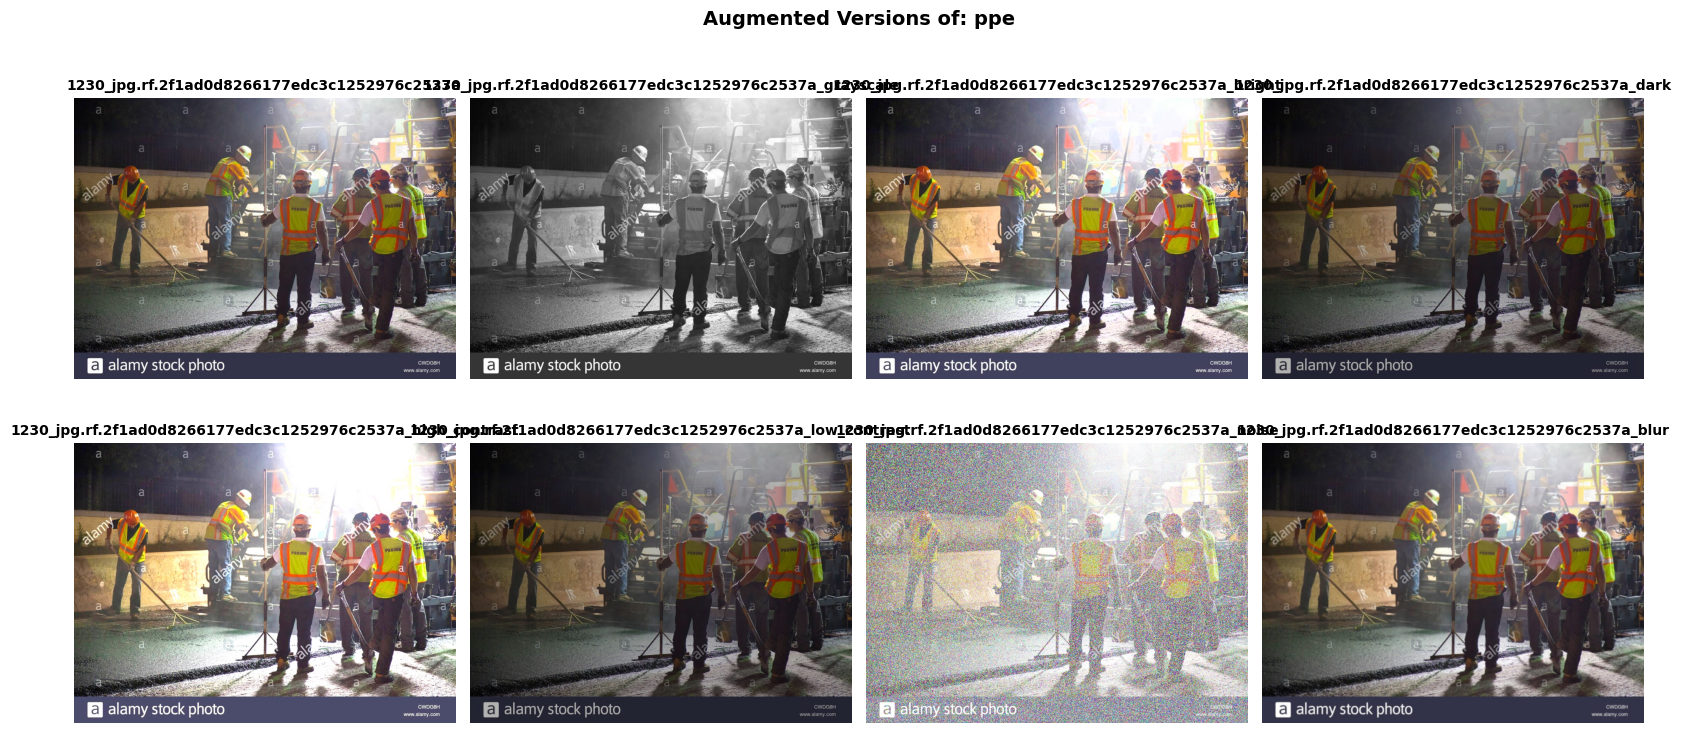

In [ ]:

print("\n" + "="*60)
print("VISUALIZING AUGMENTED SAMPLES")
print("="*60)

# Get samples
augmented_images_list = list(Path('/content/drive/MyDrive/Colab Notebooks/Capstone 4/extracted/train_augmented/images').glob('*.jpg'))

# Pilih 1 gambar original dan semua variasinya
base_name = augmented_images_list[0].stem.split('_')[0]
related_images = [
    img for img in augmented_images_list
    if img.stem.startswith(base_name)
][:8]  #  maksimal 8 variasi

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx, img_path in enumerate(related_images):
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Extract augmentation type from filename
    aug_type = img_path.stem.replace(base_name, '').strip('_')
    if not aug_type:
        aug_type = 'original'

    axes[idx].imshow(img_rgb)
    axes[idx].set_title(f'{aug_type}', fontsize=10, fontweight='bold')
    axes[idx].axis('off')

# Hide unused subplots
for idx in range(len(related_images), 8):
    axes[idx].axis('off')

plt.suptitle(f'Augmented Versions of: {base_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Capstone 4/results/augmented_samples_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



# 9. STATISTICS SUMMARY


AUGMENTATION SUMMARY

Original training images: 997
Augmented training images: 11964
Multiplication factor: 12.00x

Augmentation techniques applied: 11
Each image now has 12 versions (original + augmented)


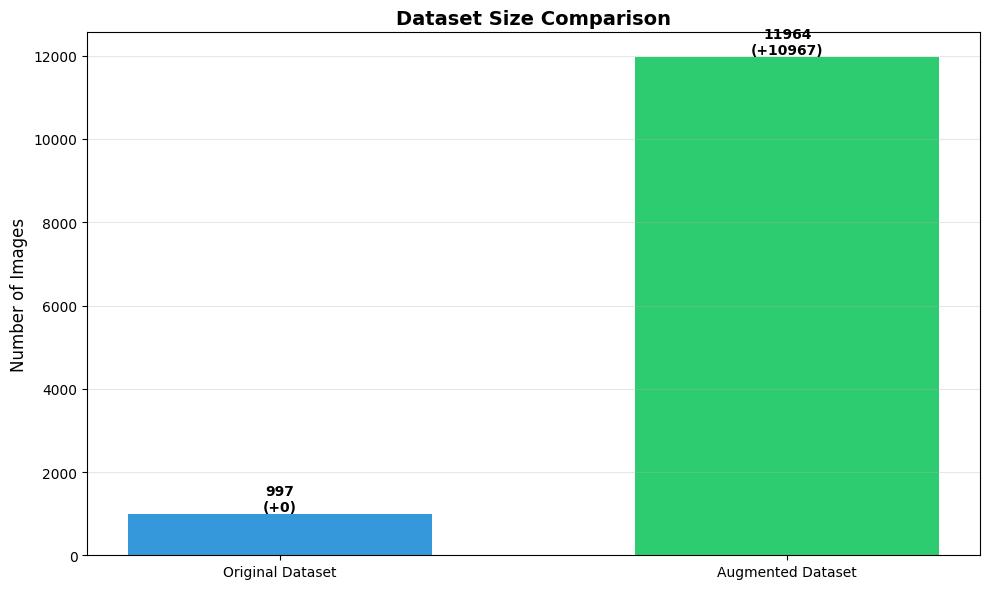

In [ ]:
print("\n" + "="*60)
print("AUGMENTATION SUMMARY")
print("="*60)

original_train_count = len(list(Path('/content/drive/MyDrive/Colab Notebooks/Capstone 4/extracted/train/images').glob('*.jpg')))
augmented_train_count = len(list(Path('/content/drive/MyDrive/Colab Notebooks/Capstone 4/extracted/train_augmented/images').glob('*.jpg')))
multiplication_factor = augmented_train_count / original_train_count

print(f"\nOriginal training images: {original_train_count}")
print(f"Augmented training images: {augmented_train_count}")
print(f"Multiplication factor: {multiplication_factor:.2f}x")
print(f"\nAugmentation techniques applied: {len(augmentation_techniques)}")
print(f"Each image now has {len(augmentation_techniques) + 1} versions (original + augmented)")

# Create comparison chart
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Original Dataset', 'Augmented Dataset']
counts = [original_train_count, augmented_train_count]
colors = ['#3498db', '#2ecc71']

bars = ax.bar(categories, counts, color=colors, width=0.6)

ax.set_ylabel('Number of Images', fontsize=12)
ax.set_title('Dataset Size Comparison', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}\n(+{count - original_train_count if count != original_train_count else 0})',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Capstone 4/results/dataset_size_comparison.png', dpi=300, bbox_inches='tight')
plt.show()